# 7.2 - Sınıflandırma Problemler: Lojistik Regresyon ile Sınıflandırma
1) Bu ödevde, modelinizi kullanarak Titanic faciasında hayatta kalma durumunu tahmin edeceksiniz. Bu ödevi tamamlamak için, aşağıdaki görevlerin çözümlerini içeren bir Jupyter not defterini link olarak gönderin. Kafanıza takılan konuları mentörünüzle konuşabilir ya da ofis saatinde Slack üzerinden sorabilirsiniz.
* [Titanic](https://www.kaggle.com/c/titanic/data) verilerini Kaggle'dan indirin. Buradaki train.csv dosyasındaki veriler ihtiyacınızı görecektir.
* Verilerinizi eğitim ve test kümelerine ayırın.
* Modelinizi oluşturarak ayırdığınız test kümesindeki verilere göre hayatta kalma durumlarını tahmin edin
* Modelinizin performansı tatmin edici mi? Açıklayın.
* Bazı değişkenleri ekleyerek veya çıkararak modelinizi tahmin performansı açısından geliştirmeye çalışın.

2) Lojistik Regresyon'un avantaj ve dezavantajlarını araştırın ve mentörünüzle tartışın.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings; warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, PolynomialFeatures

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

title_font = {"family":"arial", "color":"black", "weight":"bold", "size":16}
axis_font = {"family":"serif", "color":"gray", "weight":"normal", "size":14}

train_data = pd.read_csv("titanic_train.csv")
test_data = pd.read_csv("titanic_test.csv")

In [2]:
# train data
train_data.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


***
# Soru:

In [3]:
print("Veri:", train_data.Age[5])
print("Veri tipi:", type(train_data.Age[5]), "\n")

## aşağıdaki neden False oluyor?
print("NaN mı:", train_data.Age[5] == np.nan)

Veri: nan
Veri tipi: <class 'numpy.float64'> 

NaN mı: False


***

In [4]:
# test data
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Kategorik değişkenleri numerik yapalım.
for data in (train_data, test_data):
    # Cinsiyet değişkenini ikili değere dönüştürdük.
    is_male_series = pd.get_dummies(data["Sex"], drop_first=True)
    data.insert(loc=4, column="is_male", value=is_male_series)
    data.drop(labels="Sex", axis=1, inplace=True)
    
    # 3 farklı biniş limanını sayısal değere dönüştürdük
    data.Embarked = data.Embarked.replace("S", 3)    # S = Southampton
    data.Embarked = data.Embarked.replace("Q", 2)    # Q = Queenstown
    data.Embarked = data.Embarked.replace("C", 1)    # C = Cherbourg
    data.Embarked = data.Embarked.replace(np.nan, 0)
    
    # Sayısal değere dönüşen sütunun veri tipini güncelledik.
    data.Embarked = data.Embarked.astype("uint8")

In [6]:
# "Age" değişkenindeki boş değerleri, cinsiyet ortalamalarıyla değiştirdik.
temp_index = 0
for age in (train_data.Age):
    if np.isnan(age):
        mean_age_by_sex = train_data.Age.groupby(by=train_data.is_male).mean()
        train_data.loc[temp_index, "Age"] = mean_age_by_sex[train_data.is_male[temp_index]]
    temp_index +=1    
del temp_index

In [7]:
# Modelimizin bağımsız ve bağımlı değişkenlerini tanımlayalım.
# Ayrıca, bağımsız değişkenleri standartlaştırarak olası katsayı ağırlık farklarını düşürelim.
X_train = scale(train_data[["Pclass", "is_male", "Fare", "Age", "SibSp", "Parch", "Embarked"]])
Y_train = train_data["Survived"]

In [8]:
# Kuracağımız modelde, farklı C değerleri deneyeceğiz.
# C: Inverse of regularization strength 
C_values = np.logspace(-10, 10, 500)

In [9]:
accuracy_values = pd.DataFrame(columns=["C Values", "Train Accuracy"])
for c in C_values:
    logistic_reg = LogisticRegression(penalty="l2", 
                                      solver="lbfgs", 
                                      multi_class="multinomial", 
                                      C=c, 
                                      max_iter=1000)
    logistic_reg.fit(X_train, Y_train)
    score = logistic_reg.score(X_train, Y_train)
    
    accuracy_values = accuracy_values.append({"C Values":c, "Train Accuracy":score}, 
                                             ignore_index=True)

In [10]:
print("Bazı C değerlerinin doğruluk oranları:")
accuracy_values.iloc[0:500:100]

Bazı C değerlerinin doğruluk oranları:


,C Values,Train Accuracy
0,1.000000e-10,0.616162
100,1.018629e-06,0.616162
200,1.037605e-02,0.804714
300,1.056935e+02,0.801347
400,1.076624e+06,0.801347


In [11]:
index_of_max = accuracy_values.index[accuracy_values["Train Accuracy"] 
                      == accuracy_values["Train Accuracy"].max()][0]

accuracy_of_max = accuracy_values["Train Accuracy"][index_of_max]
c_of_max = accuracy_values["C Values"][index_of_max]

print(f"En yüksek skorun ({accuracy_of_max:.3f}) C değeri: {c_of_max:.4g}")

En yüksek skorun (0.816) C değeri: 0.004123


In [12]:
log_reg = LogisticRegression(solver="lbfgs", 
                             multi_class="multinomial", 
                             C=c_of_max, 
                             max_iter=1000)

log_reg.fit(X_train, Y_train)
print("İlk modelimizin performansı: {:.4f}".format(log_reg.score(X_train, Y_train)))

İlk modelimizin performansı: 0.8159


In [13]:
# "polynomial features" ile değişkenlerimizin etkileşimini gözlemleyeceğiz
poly_model = PolynomialFeatures(degree=5, interaction_only=False, order="C")
X_train_poly = poly_model.fit_transform(X_train)

In [14]:
# Uygulanan model: 
# log_reg = LogisticRegression(solver="lbfgs", multi_class="multinomial", C=c_of_max, max_iter=1000)

log_reg.fit(X_train_poly, Y_train)
print("Polinom etkileşimi ile denen ilk modelin performansı: {:.4f}".format(log_reg.score(X_train_poly, Y_train)))

Polinom etkileşimi ile denen ilk modelin performansı: 0.8653


In [15]:
# Kabin sütununu da dummy değişkenleriyle güncelleyerek performanstaki değişime bakalım.
train_data = pd.concat([train_data, pd.get_dummies(train_data["Cabin"], drop_first=True)], axis=1)
train_data.drop(labels=["Cabin", "PassengerId", "Name", "Ticket"], axis=1, inplace=True)

In [16]:
X_train = scale(train_data.iloc[:,1:])
Y_train = train_data["Survived"]

In [17]:
log_reg.fit(X_train, Y_train)
print("Kabin sütunu düzenlemesinin ardından modelimizin performansı: {:.4f}".format(log_reg.score(X_train, Y_train)))

Kabin sütunu düzenlemesinin ardından modelimizin performansı: 0.8530


In [18]:
# polynomial features
poly_model = PolynomialFeatures(degree=2, interaction_only=True, order="C")
X_train_poly = poly_model.fit_transform(X_train)

# LogisticRegression(solver="lbfgs", multi_class="multinomial", C=c_of_max, max_iter=1000)

log_reg.fit(X_train_poly, Y_train)
print("2. derece polinom etkileşimi ile denen modelin performansı: {:.4f}".format(log_reg.score(X_train_poly, Y_train)))

2. derece polinom etkileşimi ile denen modelin performansı: 0.8754


In [19]:
# polynomial features
poly_model = PolynomialFeatures(degree=3, interaction_only=True, order="C")
X_train_poly = poly_model.fit_transform(X_train)

# LogisticRegression(solver="lbfgs", multi_class="multinomial", C=c_of_max, max_iter=1000)

log_reg.fit(X_train_poly, Y_train)
print("3. derece polinom etkileşimi ile denen modelin performansı: {:.4f}".format(log_reg.score(X_train_poly, Y_train)))

3. derece polinom etkileşimi ile denen modelin performansı: 0.8765


In [21]:
# polynomial features
poly_model = PolynomialFeatures(degree=3, interaction_only=False, order="C")
X_train_poly = poly_model.fit_transform(X_train)

# LogisticRegression(solver="lbfgs", multi_class="multinomial", C=c_of_max, max_iter=1000)

log_reg.fit(X_train_poly, Y_train)
print("3. derece ve tam polinom etkileşimi ile denen modelin performansı: {:.4f}".format(log_reg.score(X_train_poly, Y_train)))

3. derece ve tam polinom etkileşimi ile denen modelin performansı: 0.8810


# Sonuç:
Modelimizin performansını yükselten faktörler: <br>
* Yaş sütunundaki NaN değerlerin, ilgili verinin cinsiyetinin yaş ortalaması ile değiştirilmesi.
* Lojistik regresyondaki C değerinin değiştirilmesi
* Lojistik regresyondaki maksimum iterasyonun yükseltilmesi
* Değişkenlerin hepsinin kullanılması
    * "Pclass", "is_male", "Fare", "Age" vb.
* Polynomial Features kullanılarak değişkenlerin birbirleriyle etkileşim sağlanması
* Ve son olarak "Cabin" değişkeninin dummy değişkenine dönüştürülerek yüksek dereceli polinom etkileşimine sokulması
***

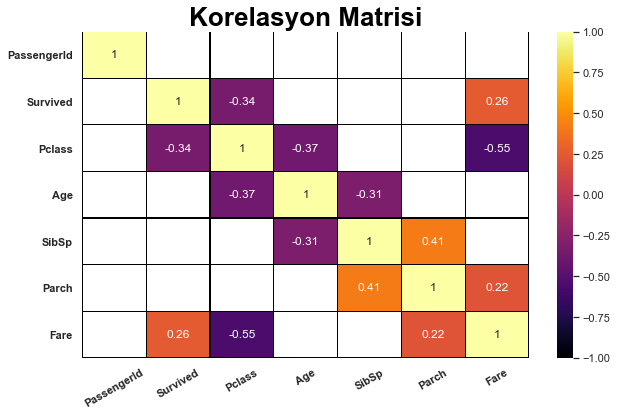

In [23]:
train_data = pd.read_csv("titanic_train.csv")
train_data_corr = train_data.corr()

sns.heatmap(train_data_corr[abs(train_data_corr)>0.2], 
            annot=True, 
            linecolor="black", linewidth=0.1, 
            vmin=-1, vmax=1, 
            cmap="inferno")
plt.yticks(rotation=0, weight="bold")
plt.xticks(rotation=30, weight="bold")
plt.title("Korelasyon Matrisi", fontdict = title_font, size=26)
plt.show()

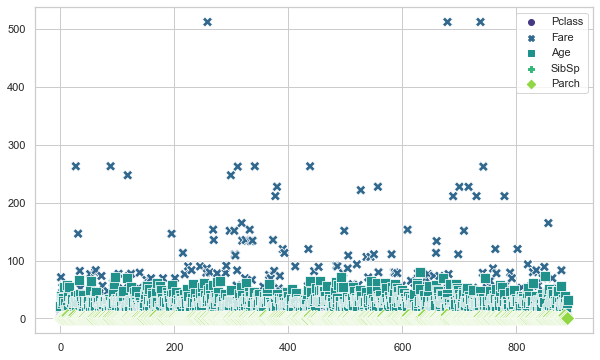

In [31]:
scatter_data = train_data[["Pclass", "Fare", "Age", "SibSp", "Parch"]]

sns.scatterplot(data=scatter_data, 
                s=100, 
                hue = train_data.Survived, 
                palette = 'viridis')

plt.show()